# Vector Databases

In the previous section of this workshop, we discussed the importance of embedding a language's semantics in vectors (typically with hundreds of dimensions). These vector representations are not simply meant to be used as inputs to train deep learning models: there are multiple, key applications in search and recommendation without much machine learning - just similarity search. For example, Spotify heavily uses [vector search](https://engineering.atspotify.com/2022/03/introducing-natural-language-search-for-podcast-episodes/) to power its features.

After ChatGPT release, practitioners realised they could combine the natural language capabilities of LLMs to manipulate the results of vector search to enhance your queries. The bottleneck, in the end, is always speed: that's why vector databases are so popular. What are they, why are they necessary, and how do they work? Let's get started!

In [ ]:
import importlib

if not importlib.util.find_spec("movie_buddy"):
    !pip install -qqq git+https://github.com/xtreamsrl/movies-buddy

## Comparing Vectors Using Distance Metrics

One of the main advantages of having text represented as a vector is that we can compare them, such as by measuring their distance relative to each other or any other new element. In this way, we can retrieve the most similar results!

Using different distance metrics, we can calculate how much two points in a multidimensional space are close to each other. The most commonly used in the context of NLP are: 

- **Cosine similarity**: measures the angle between vectors, so it's about direction, not magnitude.
- **Dot product**: measures both the angle and the magnitude of vectors.
- **Euclidean distance**: measures the straight-line distance between points.
- **Manhattan distance**: measures the distance between points along a grid, like city blocks.

Each one is useful in different situations, depending on what aspects of the data are most important for your specific problem.

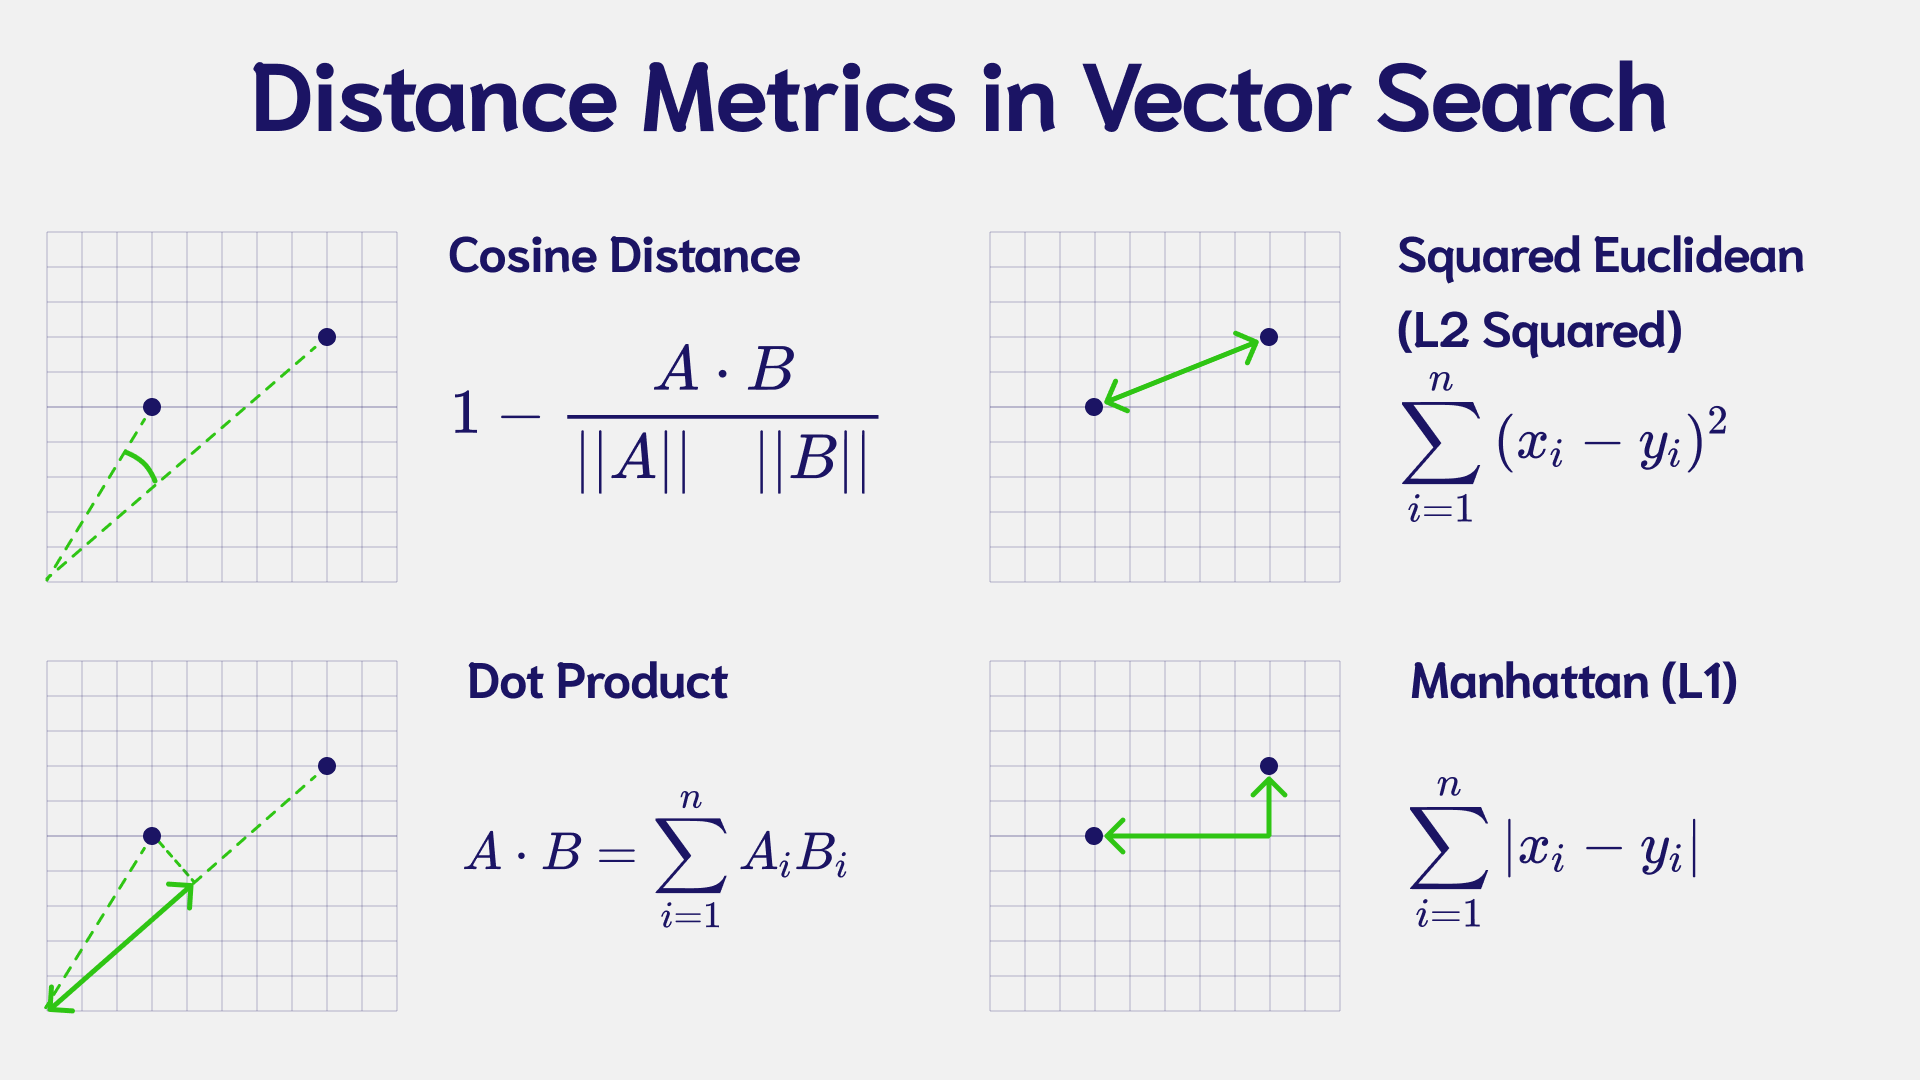

Here's another mathematical formulation you might see around for distance metrics:

<center>

name | formula
-----|--------
Cosine Similarity | $$d(a, b) = \cos(\theta) = \frac{\sum_{i=1}^{n} a_i b_i}{\sqrt{\sum_{i=1}^{n} a_i^2} \cdot \sqrt{\sum_{i=1}^{n} b_i^2}}$$
Dot Product | $$d(a, b) = a \cdot b = \sum_{i=1}^{n} a_i b_i$$
Euclidean Distance | $$d\left( a,b\right)   = \sqrt {\sum _{i=1}^{n}  \left( a_{i}-b_{i}\right)^2 }$$
Manhattan Distance | $$d(a, b) = \sum_{i=1}^{n}abs{a_i - b_i}$$

</center>


### Distance Metrics Properties

Not every measurement can become a distance metric. To invent your own, it should satisfy some mathematical properties.

Given two vectors $a$ and $b$, a distance metric $d$ must be:

1. **Non-negative**: $d(a, b) >= 0$;

2. **Symmetric**: $d(a, b) = d(a, b)$;

3. **Respect triangle inequality**: $d(a, b) <= d(a, r) + d(r, b)$ for all vectors $a$, $b$, $r$;

4. $d(p, q)=0$ only if $p=q$.

## Nearest Neighbour Search

In [ ]:
import numpy as np
from scipy.spatial.distance import cityblock, euclidean, cosine

vector_a = np.array([0.9, 0.1, 0.23, 0.15])
vector_b = np.array([0.9, 0.30, 0.23, 0.25])

cosine_distance = cosine(vector_a, vector_b)
dot_distance = np.dot(vector_a, vector_b)
euclidean_dist = euclidean(vector_a, vector_b)
manhattan_dist = cityblock(vector_a, vector_b)

print(
    f"Cosine: {cosine_distance}\nDot: {dot_distance}\nEuclidean: {euclidean_dist}\nManhattan: {manhattan_dist}\n"
)

## Nearest Neighbour Search

Now we have a way to represent pieces of text as vectors, and distance metrics to compare them. The last piece to make an application out of these components is a way to search for the most similar vectors.

Naive (or brute force) **Nearest Neighbour Search** is quite trivial to implement:

In [ ]:
def k_closest_vectors(
    target_vec: np.ndarray, vectors: np.ndarray, k: int
) -> np.ndarray:
    distances = np.sqrt(np.sum((vectors - target_vec) ** 2, axis=1))
    k_closest_indices = np.argsort(distances)[:k]
    closest_vectors = vectors[k_closest_indices]
    return closest_vectors

Let's forget for a moment of real sentences and generate a bunch of random vectors:

In [ ]:
VECTOR_DIMENSIONS = 500
N_VECTORS = 500_000
K = 3

vectors = np.random.uniform(low=0.0, high=1, size=(N_VECTORS, VECTOR_DIMENSIONS))

# the vector to search
query_vector = np.random.uniform(low=-1, high=1, size=(VECTOR_DIMENSIONS,))

Let's see how our native approach works.

In [ ]:
import time

s_time = time.time()
closest_vectors = k_closest_vectors(query_vector, vectors, K)
nn_time = time.time() - s_time

f"To get the closer {K} vectors with naive K-Nearest-Neighbour algorithm took {nn_time:.2} sec"

Try increasing the N_VECTORS parameter. How long does this take? It's easy to see how and why this approach does not scale: K-Nearest-Neighbour is a $O(N)$ algorithm.

An alternative approach is to trade some accuracy for some speed, with Approximate Nearest Neighbours (ANN). There are a lot of ANN algorithms:

### HNSW: Hierarchical Navigable Small Worlds
**Type**: Graph-based
**How It Works**: Imagine navigating a city not by walking through every street but by using shortcuts and hierarchies, like jumping from neighborhood to neighborhood before drilling down to specific streets. HNSW constructs a multi-layered graph where each layer is a more coarse-grained approximation of the data. Searches start at the top layer using these broad shortcuts, then move down to increasingly finer details, making the search efficient even in very large datasets. It's akin to starting from a bird's-eye view of the city and zooming in step-by-step to your destination.

* [How it works](https://towardsdatascience.com/similarity-search-part-4-hierarchical-navigable-small-world-hnsw-2aad4fe87d37)
* [Original paper](https://arxiv.org/abs/1603.09320)

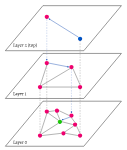

### ANNOY: Approximate Nearest Neighbor Oh Yeah
**Type**: Tree-based
**How It Works**: Think of ANNOY as organizing data points into a forest of binary trees, where each tree is constructed by repeatedly choosing two points at random and dividing the space into two partitions based on which side of the line (defined by these points) other points fall. This process creates a set of trees where similar items are likely to end up in the same leaf or nearby leaves. When querying, ANNOY traverses these trees, quickly narrowing down the areas where the nearest neighbors are likely to be found. It's like having a map where similar things are grouped together, and finding what you want becomes faster because you know which area to look in.

* [How it works](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html)
* Curious about code? Repo [here](https://github.com/spotify/annoy)

### LSH: Locality Sensitive Hashing
**Type**: Hash-based
**How It Works**: Imagine trying to find documents with similar topics in a huge library. Instead of reading through each, you could assign a unique stamp to each document based on its main themes. Documents with similar themes would have similar stamps, making it easier to find related documents just by comparing stamps. LSH works by transforming data points into a hash code such that similar items are more likely to be hashed to the same "bucket" or a nearby bucket. During a search, only items in the same or adjacent buckets are compared, significantly speeding up the search process for similar items. It’s a way of organizing items so that one can quickly find items in the same category without exhaustive search.

* [How it works](https://www.notion.so/Vector-Database-101-1a1926611dc548c1a01a8f939a9dc42c?pvs=21)

For the rest of our examples, we will use [Qdrant](https://qdrant.tech/) to build our LLM-powered application. Qdrant is a popular open source vector database. It implements HNSW and can both be used as an in-memory database or as a disk-based one.

## Get started with Qdrant

Let's try to load our random vectors inside a qdrant collection.

After installing qdrant-client, we need to create an instance of the client. Then, we create a "collection", i.e. an equivalent of a database table. A collection is a named set of points (vectors with a payload) among which you can search. The vector of each point within the same collection must have the same dimensionality and be compared by a single metric. Vectors can also have a payload, i.e. metadata attached to them.

A collection needs to be created with a name and a vector configuration. The vector configuration includes the **vector size** and the **distance metric**. This are fixed, and cannot be changed. Only vectors of the same size can be added to the same collection. The distance metrics will be used to perform the approximate search. The choice of the distance metrics also depends on the method of neural network encoder training.

In [ ]:
from qdrant_client import models, QdrantClient

qdrant = QdrantClient(":memory:")

COLLECTION_NAME = "random_vectors"
DISTANCE = models.Distance.COSINE

qdrant.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(size=VECTOR_DIMENSIONS, distance=DISTANCE),
)

Here we created a very basic collection. Qdrant's [documentation](https://qdrant.tech/documentation/concepts/collections) explores all of their capabilities, such as how to configure some of the optimisation they can perform. Qdrant can store sparse vectors or quantize them to increase performance.

Here we upload our vectors to the collection with the `upload_collection` method. This performs batch uploads. The operation is slow, since the database needs to build the index structure to subsequently perform the ANN search. By default, qdrant creates an index when there are more than 20_000 records (below said threshold, brute force search is used). We can control this threshold with the `indexing_threshold` parameter, as explained [here](https://qdrant.tech/documentation/tutorials/bulk-upload/#disable-indexing-during-upload).

In [ ]:
qdrant.upload_collection(collection_name=COLLECTION_NAME, vectors=vectors)

We can retrieve some information about our collection in this way:

In [ ]:
qdrant.get_collection(collection_name=COLLECTION_NAME)

However, keep in mind that the number of vectors is an approximation.

In [ ]:
s_time = time.time()
qdrant.search(collection_name=COLLECTION_NAME, query_vector=query_vector, limit=K)
ann_time = time.time() - s_time

f"To get the closest {K} vectors with a vector database took {ann_time:.2} sec"

## What About Movies?

You should now be and expert in embeddings, nearest-neighbours search and vector databases such as qdrant. How about you try yourself to import our movies dataset in a new collection? To avoid re-compunting the embeddings, you can use the `get_embeddings` function.

In [ ]:
from movie_buddy.data import get_embeddings, get_movies_dataset

movies, movies_embeddings = get_movies_dataset(), get_embeddings()

### Build the Collection

As a first step, you still need to import the encoding model. Its size will be used to determine the size of the collection. Use the same model as in the previous notebook:

In [ ]:
encoder = ...

Create a `QdrantClient` in-memory instance. Create a collection named `movies`.

To determine the vector configuration, use the `get_sentence_embedding_dimension` method of the encoder. Use cosine distance.

In [ ]:
qdrant = ...

COLLECTION_NAME = ...

# (re)create the collection named `COLLECTION_NAME`

The smallest instance of Qdrant is a `Record`. The vector contains an index number, a record and a payload. Like this:

In [ ]:
rec = models.Record(
    id=1,
    vector=movies_embeddings[0],
    payload={
        "title": movies.iloc[0]["title"],
        "overview": movies.iloc[0]["overview"],
        "release_date": movies.iloc[0]["release_date"],
        "runtime": movies.iloc[0]["runtime"],
        "genre": movies.iloc[0]["genre"],
    },
)

rec

It's your turn. Create a list of records that will be uploaded to the collection.

In [ ]:
records = ...

To upload the records, use `qdrant.upload_points`.

In [ ]:
...

Now, you can have fun searching your prefered movies!

Just define a `query` variable, encode it and use `qdrant.search`. This will return a list of hits.

In [ ]:
prompt = ...
encoded_prompt = ...

results = qdrant.search()

In [ ]:
for result in results:
    payload = result.payload
    print(
        "Title: {title}\nRelease date: {release_date}\nRuntime: {runtime}\n\n".format(
            title=payload["title"],
            release_date=payload["release_date"],
            runtime=payload["runtime"],
        )
    )